In [1]:
#import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.ndimage.filters import gaussian_filter
import pickle
from glob import glob
import os

In [2]:
def plot_MNE(pfinals, sub,ses,ch, neu, lab, n_eigvec_to_display=6, sdim=256):

    a_avg = 0
    j_avg = 0
    n_jackknives = len(pfinals)
    for jack, pfinal in enumerate(pfinals):
        # extract a matrix 
        a = pfinal[1:sdim+1]
        a = np.reshape(a,(16,16))
        a_avg += a
        # extract J matrix
        j = pfinal[-1*sdim**2:]
        j = np.reshape(j,(sdim,sdim))
        j_avg += j

    a_avg /= n_jackknives
    j_avg /= n_jackknives

    eigval, eigvec = np.linalg.eig(j_avg)
    # display recovered rf to generative rf
    eigval_ixd = [(eigval[i],i) for i in range(len(eigval))]
    eigval_ixd.sort()
    sorted_eigval, permt = zip(*eigval_ixd)
    
    eigval_std = np.std(sorted_eigval)
    eigval_avg = np.mean(sorted_eigval)

    topn_negative = [np.reshape(eigvec[:, permt[x]], (16, 16)) for x in range(n_eigvec_to_display)]
    topn_positive = [np.reshape(eigvec[:, permt[x]], (16, 16)) for x in range(-1, -(n_eigvec_to_display+1), -1)]

    fig = plt.figure(constrained_layout=True, figsize=(13.3, 10))
    gs = fig.add_gridspec(4, n_eigvec_to_display)

    neg_axs = []
    pos_axs = []
    for idx, v in enumerate(topn_negative):
        ax = fig.add_subplot(gs[0, idx])
        neg_axs.append(ax)
        ax.imshow(v, cmap=cm.jet, interpolation="gaussian", origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[idx]), fontsize=14)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)


    for idx, v in enumerate(topn_positive):
        ax = fig.add_subplot(gs[1, idx])
        neg_axs.append(ax)
        ax.imshow(v, cmap=cm.jet, interpolation="gaussian", origin='lower', aspect='equal')
        ax.set_title('{:.3f}'.format(sorted_eigval[-(idx+1)]), fontsize=14)
        ax.tick_params(labelbottom=False, labelleft=False, direction='in', bottom=False, left=False)
    
    ax_eigs = fig.add_subplot(gs[2:, :4])
    ax_eigs.fill_between(range(len(sorted_eigval)), y1=eigval_avg+eigval_std*2, y2=eigval_avg-eigval_std*2, color='grey', alpha=0.2)
    ax_eigs.axhline(y=0, c='grey')
    ax_eigs.plot(sorted_eigval, '.')
    ax_eigs.set_title('Sorted Eigenvalues of J Matrix', fontsize=18)
    ax_eigs.set_ylabel('Value', fontsize=16)
    ax_eigs.set_xlabel('Index', fontsize=16)
    ax_eigs.tick_params(labelsize=14)

    ax_a = fig.add_subplot(gs[2:, 4:])
    ax_a.imshow(a_avg,cmap=cm.jet, interpolation="gaussian", origin='lower', aspect='equal')
    ax_a.set_title('h', fontsize=18)
    lab_dic = {'labeled': 'Labeled', 'unlabeled': 'Unlabeled'}
    ldic = {'d': 'δ',
        'th': 'θ',
        'a': 'α',
        'b': 'β',
        'g': 'γ',
        'hg': 'High γ'}

    fig.suptitle("Subject {} Session {} Channel {}, {} Response, {} Input".format(sub, ses, ch, ldic[neu[:-1]], lab_dic[lab]), fontsize=24)

    plt.show()

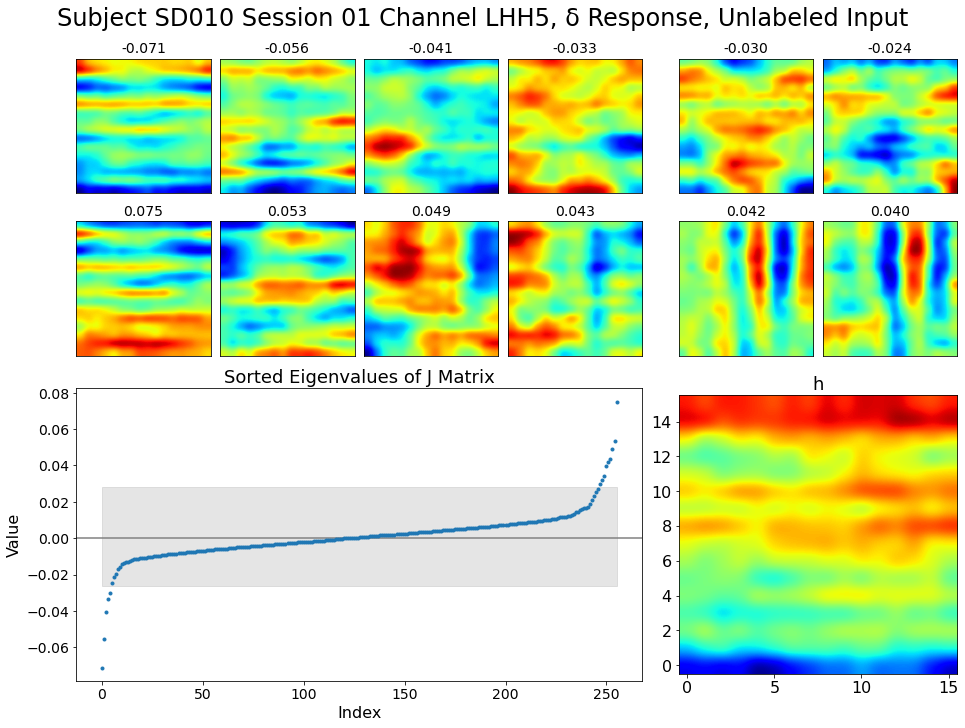

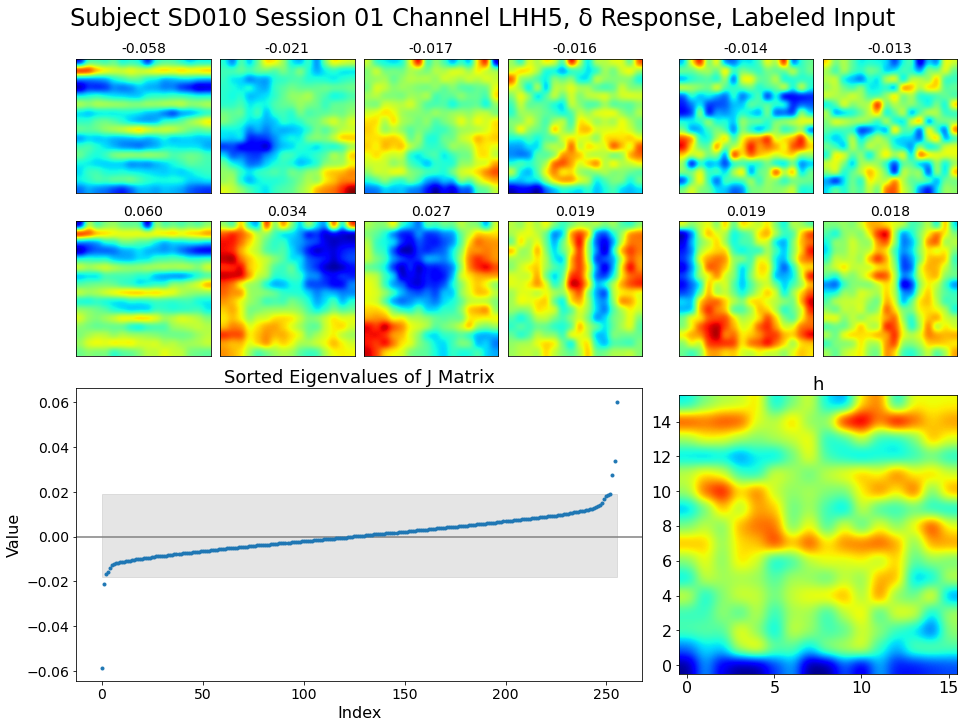

In [3]:
sub, ses = 'SD010','01'
neu = 'dp'
ch = 'LHH5'

labs=['unlabeled','labeled']
for lab in labs:
    res_path = 'Figure6/sub-SD010_ch-LHH5_all_1_MNEs_dp_{}.pkl'.format(lab)
    with open(res_path, 'rb') as f:
        pfinals = pickle.load(f)

    plot_MNE(pfinals, sub,ses,ch, neu, lab, n_eigvec_to_display=6, sdim=256)
